In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

all_results_df = pd.read_csv('../deep_learning/all_results.csv')

In [223]:
all_results_df.head()

,Unnamed: 0,unique_id,ds,NBEATS,NBEATSx,TCN,RNN,NHITS,MLP,LSTM,GRU,DilatedRNN,TFT,Informer,Autoformer,MLP_robust,NBEATSx_robust,NHITS_robust,vintage_file
0,0,1,3/31/2018,0.007760,0.006407,0.007067,0.005208,0.005570,0.004725,0.004754,0.005907,0.006073,0.001064,0.005659,0.006359,0.005901,0.006200,0.007913,vintage_2018_05
1,1,1,6/30/2018,0.007044,0.007414,0.007067,0.007846,0.007772,0.006252,0.009373,0.006786,0.007410,0.007691,0.005477,0.004458,0.007559,0.007395,0.007758,vintage_2018_05
2,2,1,9/30/2018,0.002642,0.007136,0.007067,0.005208,0.005808,0.005107,0.005297,0.005547,0.005604,0.000361,0.005520,0.006603,0.004491,0.005586,0.007855,vintage_2018_05
3,3,1,12/31/2018,0.008088,0.007688,0.007067,0.009935,0.007068,0.007151,0.013420,0.009762,0.011557,-0.003174,0.005348,0.002510,0.005623,0.007278,0.007651,vintage_2018_05
4,4,1,3/31/2018,0.004881,0.006995,0.006402,0.008227,0.011824,0.005760,0.006207,0.005415,0.005824,0.001064,0.005398,0.003111,0.007865,0.005971,0.009987,vintage_2018_06


In [224]:
all_results_df['ds'] = pd.to_datetime(all_results_df['ds'])

trel_dfs = []
for i in range(4):
    trel = all_results_df.iloc[i::4, :]
    trel = trel.drop(columns=['Unnamed: 0', 'unique_id'])
    trel_dfs.append(trel)

id_vars = ['ds', 'vintage_file']

tidy_trel_dfs = []
for trel_df in trel_dfs:
    tidy_trel = pd.melt(trel_df, id_vars=id_vars, var_name='model', value_name='value')
    tidy_trel_dfs.append(tidy_trel)

trel_values = [0, 1, 2, 3]
for trel_df, trel_value in zip(tidy_trel_dfs, trel_values):
    trel_df['trel'] = trel_value

combined_tidy_trel = pd.concat(tidy_trel_dfs, ignore_index=True)

# combined_tidy_trel['model'] = combined_tidy_trel['model'].str.replace('Auto', '')
combined_tidy_trel['vintage_file'] = combined_tidy_trel['vintage_file'].str.extract(r'(\d{4}_\d{2})')
combined_tidy_trel['vintage_file'] = combined_tidy_trel['vintage_file'].str.replace('_', '-')

In [225]:
combined_tidy_trel.head()

,ds,vintage_file,model,value,trel
0,2018-03-31,2018-05,NBEATS,0.007760,0
1,2018-03-31,2018-06,NBEATS,0.004881,0
2,2018-03-31,2018-07,NBEATS,0.005149,0
3,2018-06-30,2018-08,NBEATS,0.007181,0
4,2018-06-30,2018-09,NBEATS,0.007986,0


In [226]:
# combined_tidy_trel.to_csv('../deep_learning/tidy_results.csv', index=False)

In [227]:
df1 = combined_tidy_trel

In [228]:
def load_data(file_path):
    df = (pd.read_csv(file_path)
          .rename(columns={"year_quarter": "ds", "GDPC1": "y"})
          .assign(unique_id=np.ones(len(pd.read_csv(file_path))),
                  ds=lambda df: pd.to_datetime(df['ds'])))
    columns_order = ["unique_id", "ds", "y"] + \
        [col for col in df.columns if col not in ["unique_id", "ds", "y"]]
    df['ds'] = df['ds'] - pd.Timedelta(days=1)
    
    # Shift 'y' column by one quarter
    # df['y'] = df['y'].shift(+2)

    return df[columns_order]

file_path = '../../data/FRED/blocked/vintage_2023_02.csv'


df2 = load_data(file_path)[['ds', 'y']]

merged_df = (df1
             .merge(load_data(file_path)[['ds', 'y']], on='ds', how='left'))


In [229]:
df1

,ds,vintage_file,model,value,trel
0,2018-03-31,2018-05,NBEATS,0.007760,0
1,2018-03-31,2018-06,NBEATS,0.004881,0
2,2018-03-31,2018-07,NBEATS,0.005149,0
3,2018-06-30,2018-08,NBEATS,0.007181,0
4,2018-06-30,2018-09,NBEATS,0.007986,0
...,...,...,...,...,...
3475,2023-03-31,2022-10,NHITS_robust,0.006638,3
3476,2023-06-30,2022-11,NHITS_robust,0.013626,3
3477,2023-06-30,2022-12,NHITS_robust,-0.003883,3
3478,2023-06-30,2023-01,NHITS_robust,0.035692,3


In [230]:
df2

,ds,y
0,1959-03-31,0.022301
1,1959-06-30,0.000705
2,1959-09-30,0.002845
3,1959-12-31,0.022228
4,1960-03-31,-0.005405
...,...,...
251,2021-12-31,-0.004112
252,2022-03-31,-0.001447
253,2022-06-30,0.007980
254,2022-09-30,0.006602


In [231]:
# def calculate_rmse(row):
#     return np.sqrt((row['value'] - row['y']) ** 2)

# # Apply the function to each row
# merged_df['RMSE'] = merged_df.apply(calculate_rmse, axis=1)

# def calculate_mae(row):
#     return np.abs(row['value'] - row['y'])

# merged_df['MAE'] = merged_df.apply(calculate_mae, axis=1)

# def calculate_mape(row):
#     return np.abs((row['y'] - row['value']) / row['y']) * 100

# merged_df['MAPE'] = merged_df.apply(calculate_mape, axis=1)


In [232]:
merged_df

,ds,vintage_file,model,value,trel,y
0,2018-03-31,2018-05,NBEATS,0.007760,0,0.006949
1,2018-03-31,2018-06,NBEATS,0.004881,0,0.006949
2,2018-03-31,2018-07,NBEATS,0.005149,0,0.006949
3,2018-06-30,2018-08,NBEATS,0.007181,0,0.007194
4,2018-06-30,2018-09,NBEATS,0.007986,0,0.007194
...,...,...,...,...,...,...
3475,2023-03-31,2022-10,NHITS_robust,0.006638,3,NaN
3476,2023-06-30,2022-11,NHITS_robust,0.013626,3,NaN
3477,2023-06-30,2022-12,NHITS_robust,-0.003883,3,NaN
3478,2023-06-30,2023-01,NHITS_robust,0.035692,3,NaN


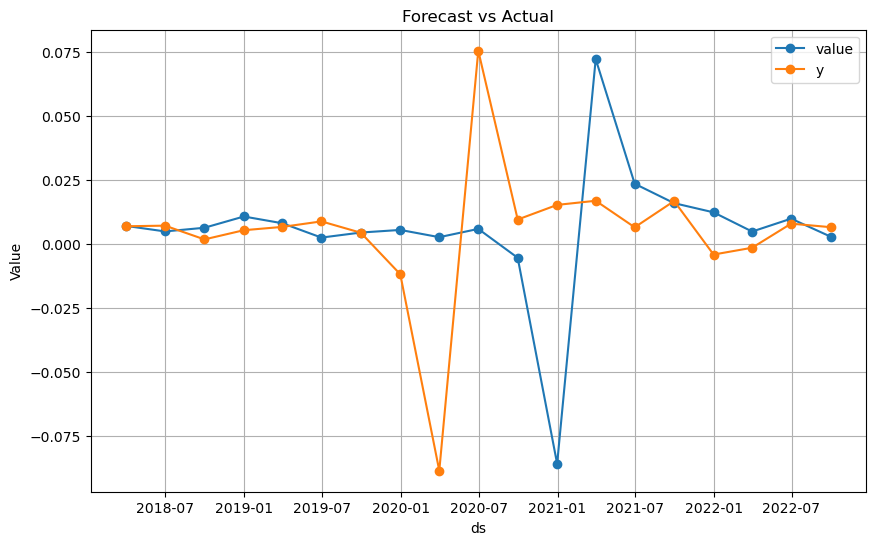

In [233]:
# Filter the dataframe where model is 'NBEATS' and 'trel' is 0
filtered_df = merged_df[(merged_df['model'] == 'RNN') & (merged_df['trel'] == 0)]

every_third = filtered_df.iloc[2::3, :]

# Plot 'ds' against 'value' and 'y'
plt.figure(figsize=(10, 6))

# Plot 'value' with 'ds'
plt.plot(every_third['ds'], every_third['value'], marker='o', label='value')

# Plot 'y' with 'ds'
plt.plot(every_third['ds'], every_third['y'], marker='o', label='y')

plt.xlabel('ds')
plt.ylabel('Value')
plt.title('Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()
